In [110]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


In [111]:
import george
from george.kernels import MyDijetKernelSimp, SignalKernel

import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit
import corner

import ROOT as r
from rootpy.plotting import Hist, Hist2D, Legend, Canvas
import rootpy.plotting.root2matplotlib as rplt



### load inputs

In [112]:
#Full bin centers (xvalO), counts (yvalO), bin width (xerrO), and bin low edges (xlowO) from ATLAS
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = list(np.load("newoutputs/xlowO.npy"))

#Same, but with bins with zero counts removed. GP fits better without zero counts
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")

#hyperparameters (kernel and mean) from GP fit to ATLAS data.





### Gaussian signal function

In [113]:
def sig_model(x, N=1e5, mass=2000., width=100., xErr=xerr):
    return N*(np.exp(-(x-mass)**2/2/width/width)/np.sqrt(2*np.pi)/width)*xErr

### Calculate z values and chi squared 

In [114]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1-2*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

#### mean and variance of non-central chi2

In [115]:
def chi2_mean_variance(DOF, nc):
    mean = nc
    variance = np.sqrt(nc)
    return mean, variance

### Poisson log likelihood

In [116]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.) 
        return lnpoisson

### remove zero count bins to use for GP fits

In [117]:
def removeZeros(data):
    indices = [i for i, x in enumerate(data) if x == 0]
    newylist=[]
    newxlist=[]
    newxerrlist=[]
    for k in range(len(data)):
        if k not in indices:
            newylist.append(data[k])
            newxlist.append(xvalO[k])
            newxerrlist.append(xerrO[k])
    return np.array(newylist), np.array(newxlist), np.array(newxerrlist)

### fit for noncentrality parameter of non central chi-squared

In [118]:
def ncchi(x, nc):
    return ss.ncx2.pdf(x, 1., nc) 

### pretty plots showing background only fit and background+signal fit

In [119]:
def makePrettyPlots_signal(xs, ys, bkgs, bkgsigs, title, mass, col = 'g', ymax = 2e5):
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    f.suptitle(title, fontsize=40)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="ATLAS data+Injected signal")
    bkg1Plot, = ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="Background only")
    bkg2Plot, = ax1.plot(xs, bkgsigs, color='r', linewidth=3.0, label="Signal-plus-background")
    ax1.legend(prop={'size':20})
    ax1.set_ylabel('Events per bin', fontsize=40)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.3, ymax])
    ax1.tick_params(axis='y', labelsize=30)
    ax1.axvline(mass, color='black', lw=1, linestyle="--")
    #ax1.arrow(mass, 1.5e2, 0, 3e2, lw=5, head_width=50, head_length=125)
    
    #bin by bin significance   
    zvals_1, chi2_1 = calcSignificance(ys, bkgs)
    print "chi2 bkg+signal mu=0", chi2_1
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_1)):
        if zvals_1[x] == np.inf or zvals_1[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals_1[x]  
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")

    rplt.bar(h1, xerr=None, yerr=None, axes=ax2)
    ax2.axhline(0, color='black', lw=1)
    #ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax2.set_xscale('log')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.set_xlim([1000, 7500])
    ax2.set_ylim([-5, 5])
    ax2.axvline(mass, color='black', lw=1, linestyle="--")
    #ax2.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)

    zvals_2, chi2_2 = calcSignificance(ys, bkgsigs)
    print "chi2 bkg+signal", chi2_2
    h2 = Hist(xlowO,markersize=0)
    for x in range(len(zvals_2)):
        if zvals_2[x] == np.inf or zvals_2[x] == -np.inf: h2[x] = 20
        else: h2[x] = zvals_2[x]  
    h2.fillstyle = 'solid'
    h2.fillcolor = 'red'
    h2.linecolor = 'black'
    h2.linewidth = 1
    h2.Draw("histX0")
    rplt.bar(h2, xerr=None, yerr=None, axes=ax3)
    ax3.axhline(0, color='black', lw=1)
    ax3.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=40)
    #ax3.set_ylabel('Significance', fontsize=20)
    ax3.set_ylabel('Sig.', fontsize=40, labelpad=20)
    ax3.set_xscale('log')
    ax3.tick_params(axis='y', labelsize=30)
    ax3.tick_params(axis='x', labelsize=30)
    ax3.set_ylim([-5, 5])
    ax3.set_xlim([1000, 7500])
    ax3.axvline(mass, color='black', lw=1, linestyle="--")
    #ax3.arrow(mass, -3, 0, 1.7, lw=5,head_width=50, head_length=0.5)
    

    ax3.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax3.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax3.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax3.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()


### plot distribution of log likelihood from fits to toys

In [126]:
def makePrettyPlots_LLH(small_LLH, large_LLH, title, drawchi2=False, xname=r'$\chi^{2}$', label1="", label2 = ""):
    f, (ax1, ax2) = plt.subplots(2, figsize=(12,12), gridspec_kw = {'height_ratios':[1, 1]})
#    f.suptitle(title, fontsize=30)
   # f.text(0.0, 0.5, 'Toy Data Experiment', va='center', rotation='vertical', fontsize=40)


    lowx = min(min(small_LLH), min(large_LLH))
    highx = max(max(small_LLH), max(large_LLH))
    bins = np.linspace(lowx, highx, 200)
    dx = bins[1]-bins[0]
    bin_centers = bins[:-1] + dx/2.
    
    hSmall, _, _ = ax1.hist(small_LLH, bins=bins, color="b")
    ax1.tick_params(axis='y', labelsize=30)
    ax1.tick_params(axis='x', labelsize=30)
    ax1.set_title(label1, fontsize=30)
    ax1.set_ylim([0.1, 10000])
    ax1.set_xlim([0, highx])
    #ax1.set_xlim([0, 30])
    ax1.set_yscale('log')
    if drawchi2:
        chi2_Small =sum(hSmall)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.)
        ax1.plot(bin_centers, chi2_Small, c='r', linewidth=2)
    
    
    hLarge, _, _ =ax2.hist(large_LLH, bins=bins, color='g')
    ax2.tick_params(axis='y', labelsize=30)
    ax2.tick_params(axis='x', labelsize=30)
    ax2.set_xlabel(xname, fontsize=40)
    ax2.set_title(label2, fontsize=30)
    ax2.set_ylim([0.1, 10000])
    ax2.set_xlim([0, highx])
    #ax2.set_xlim([0, 30])
    ax2.set_yscale('log')
    if drawchi2:
        chi2_Large = sum(hLarge)*(bins[1]-bins[0])*ss.chi2.pdf(bin_centers, 1.) 
        ax2.plot(bin_centers, chi2_Large, c='r', linewidth=2)


    plt.show()




### Poisson likelihood to use for Gaussian Process, for 3 parameter fit functions, 3 parameter fit function with signal strength parameter, 5 parameter fit function, and 5 parameter fit function with signal strength parameter. 

In [121]:
def logLike_gpLikeFF(y1, y2):
    logL = 0
    for ibin in range(len(y1)):
        data = y1[ibin]
        bkg = y2[ibin]
        logL += -simpleLogPoisson(data, bkg)
    try:
        logL
        return logL
    except:
        return np.inf  
        


### mean function for GP - 3 parameter fit function. negative log likelihood for Gaussian Process - from george. Minuit minimzation for GP negative log likelihood. Hyperparameters and mean function parameters are fixed, just fitting signal strength

In [122]:
def model_gp(params, t, xerr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * (1.-t/sqrts)**p1 * (t/sqrts)**(p2))*xerr

class logLike_gp_fitM_fixedH:
    def __init__(self, x, y, xerr, params):
        self.x = x
        self.y = y
        self.xerr = xerr
        self.params = params
    def __call__(self, mass):
        Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
        A, tau, L = self.params
        kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
        kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
        kernel = kernel1+kernel2
        gp = george.GP(kernel)
        try:
            gp.compute(self.x, np.sqrt(self.y))
            return -gp.lnlikelihood(self.y - model_gp((p0,p1,p2), self.x, self.xerr))
        except:
            return np.inf        
        
def fit_gp_fitM_fixedH_minuit(lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0)
    passedFit = False
    numRetries = 0
    while not passedFit and numRetries < 5:
        init0 = np.random.random() * 3500.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0, 
                   mass = init0, error_mass = 0.1, limit_mass = (2000, 5000)) 
        fit = m.migrad()
        if fit[0]['is_valid']: 
            passedFit=True
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args     
            
        if numRetries == 4: 
            print "retry number = ", 5, ": failed fits"
            minLLH=np.inf
            best_fit_params=(0)
        numRetries+=1
    if Print:
        print "min LL", minLLH
        print "best fit vals",best_fit_params
    return minLLH, best_fit_params




### Distribution of log likelihood ratio for Gaussian Process from george and Poisson likelihood calculations, with non central chi2 overlaid

(300, 3500, 250)
0
background only time: 0.0113389492035
best fit mass 2000.00486333
background + signal time: 0.0389108657837
chi2 bkg+signal mu=0 273.364181652
chi2 bkg+signal 273.286971367


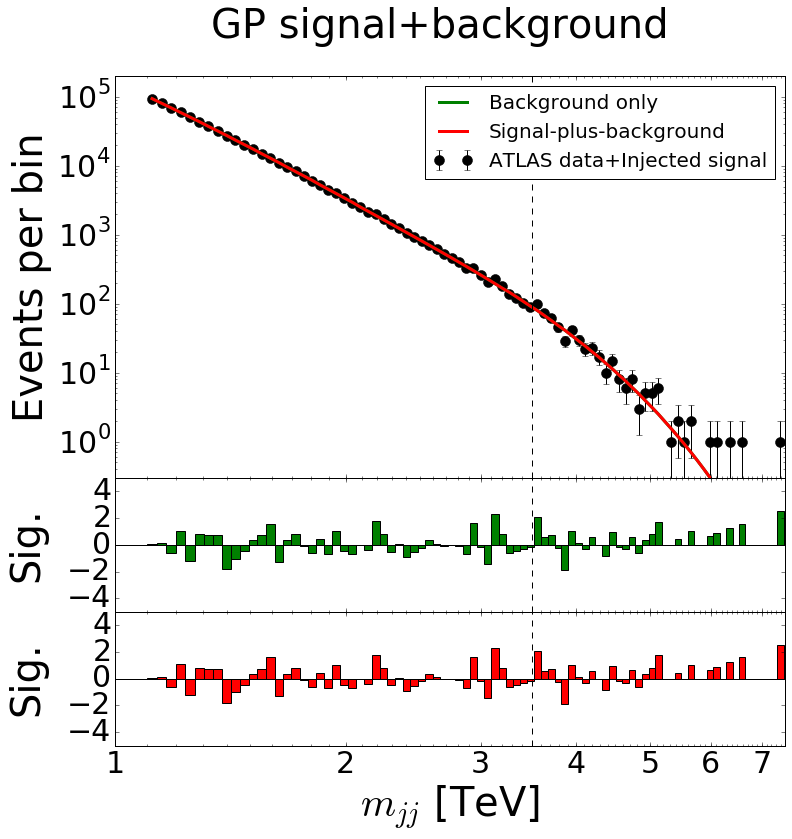

500
background only time: 0.00425696372986
best fit mass 2746.16091761
background + signal time: 0.095263004303
chi2 bkg+signal mu=0 928.004914258
chi2 bkg+signal 922.26921897


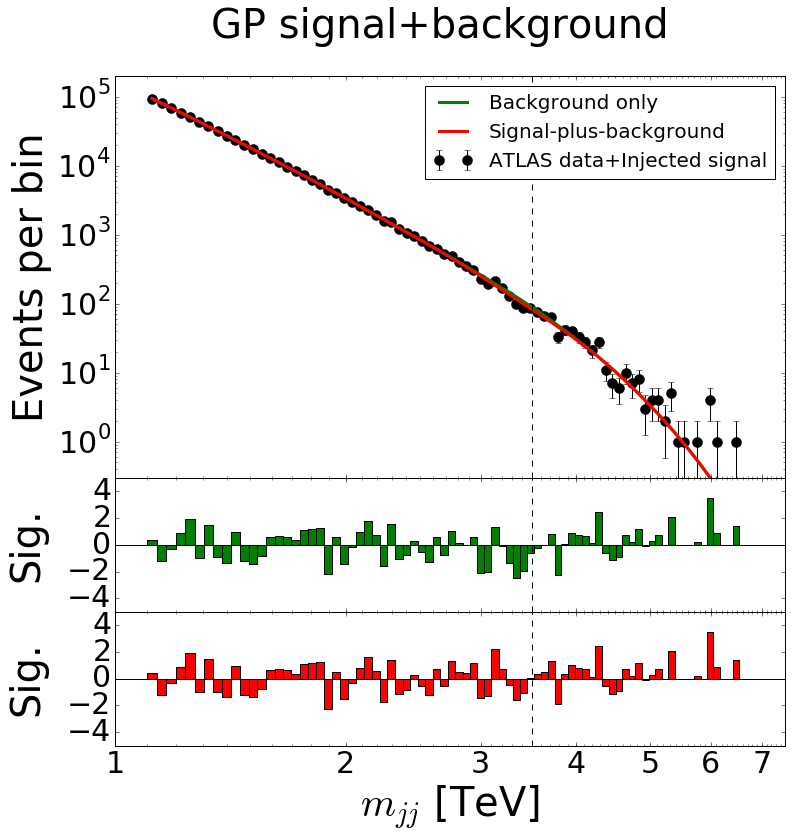

1000
background only time: 0.00296998023987
best fit mass 2334.64545677
background + signal time: 0.0430841445923
chi2 bkg+signal mu=0 204.407319533
chi2 bkg+signal 201.812843831


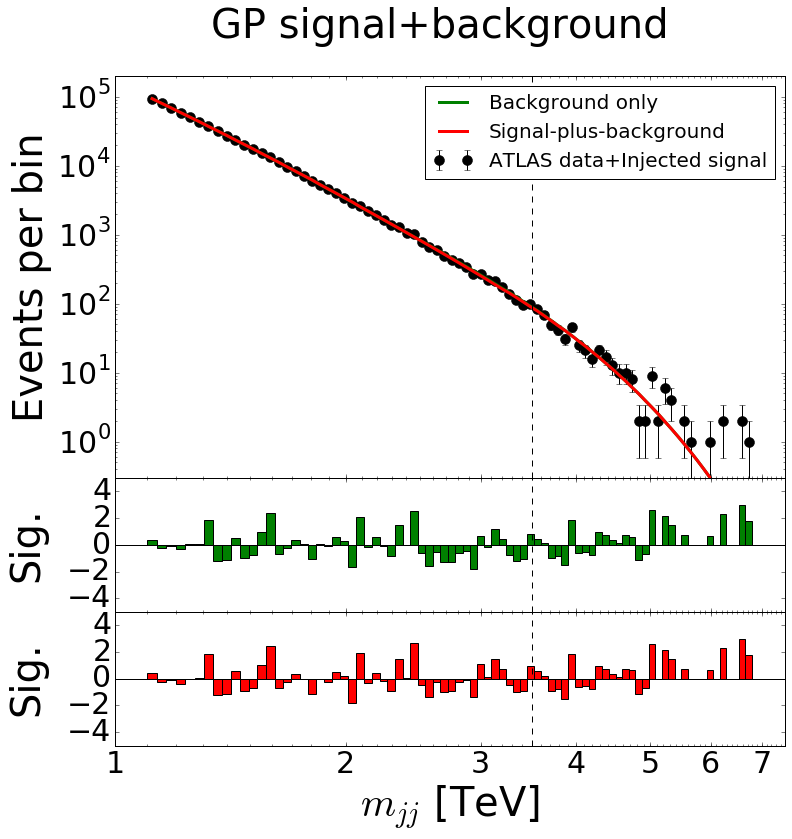

1500
background only time: 0.00371789932251
best fit mass 2712.2690031
background + signal time: 0.0728170871735
chi2 bkg+signal mu=0 160.513565034
chi2 bkg+signal 156.441623985


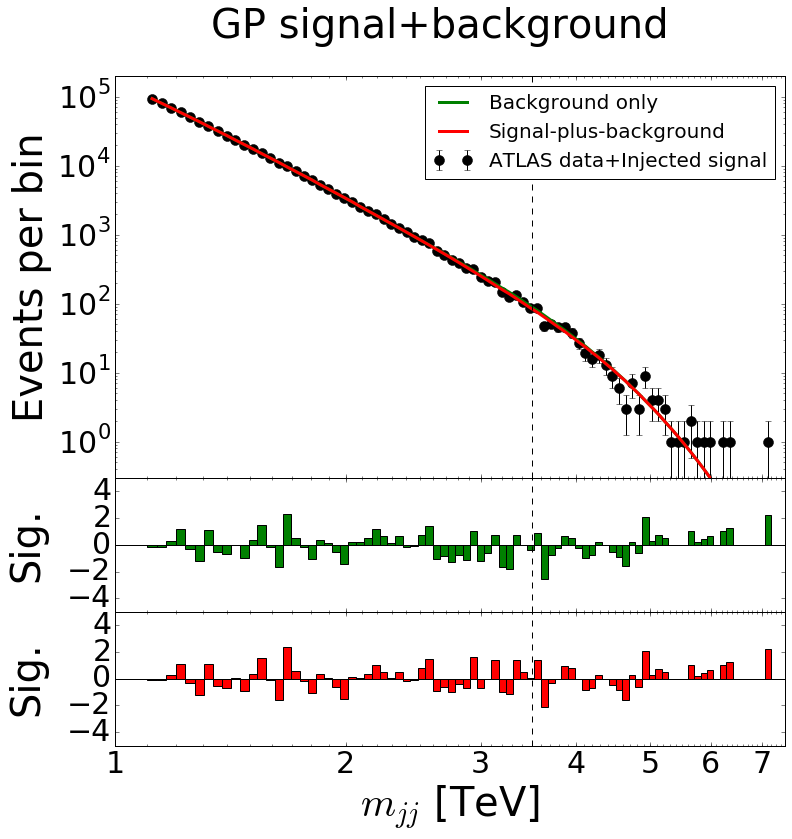

2000
background only time: 0.00377893447876
best fit mass 2574.91049055
background + signal time: 0.0811219215393
chi2 bkg+signal mu=0 142.501556844
chi2 bkg+signal 138.746413981


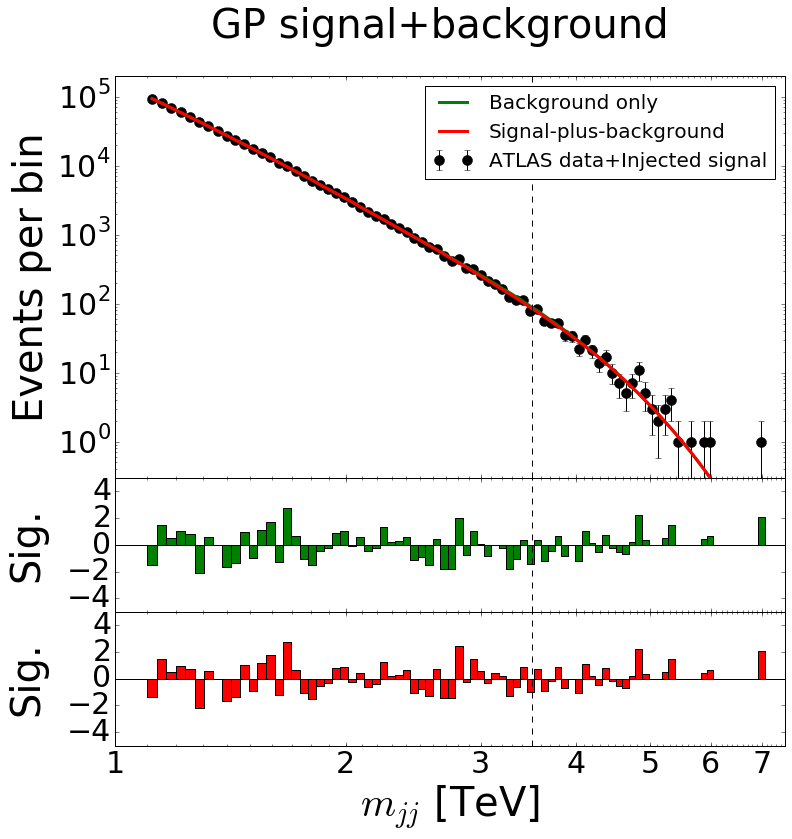

2500
background only time: 0.00322699546814
best fit mass 2781.58576305
background + signal time: 0.0625720024109
chi2 bkg+signal mu=0 95.9351842101
chi2 bkg+signal 81.7499991037


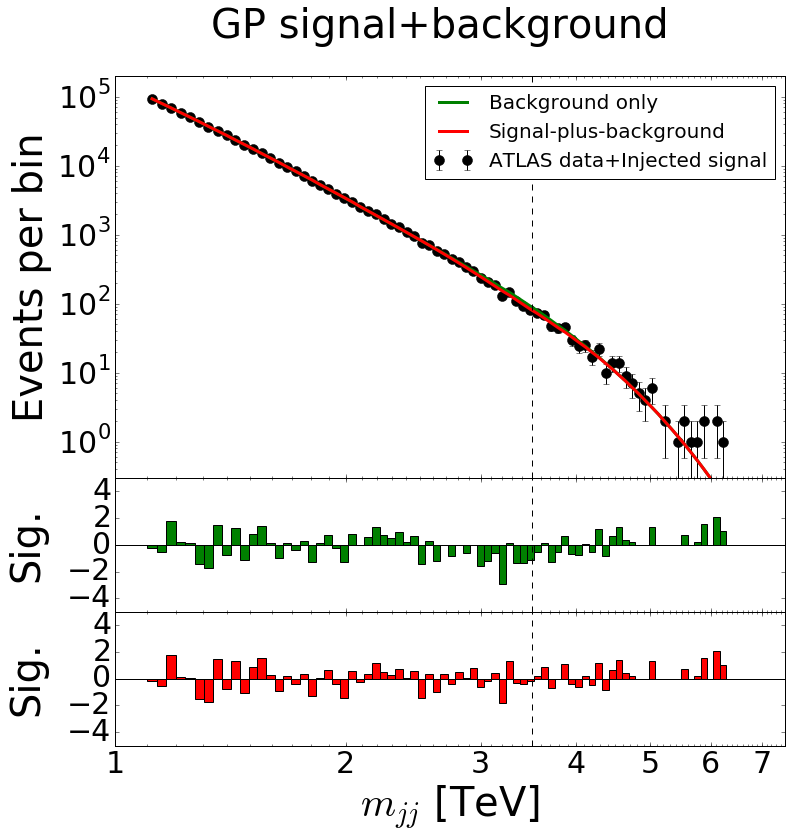

3000
background only time: 0.0029890537262
best fit mass 2768.44860484
background + signal time: 0.0565249919891
chi2 bkg+signal mu=0 130.944217586
chi2 bkg+signal 121.765237628


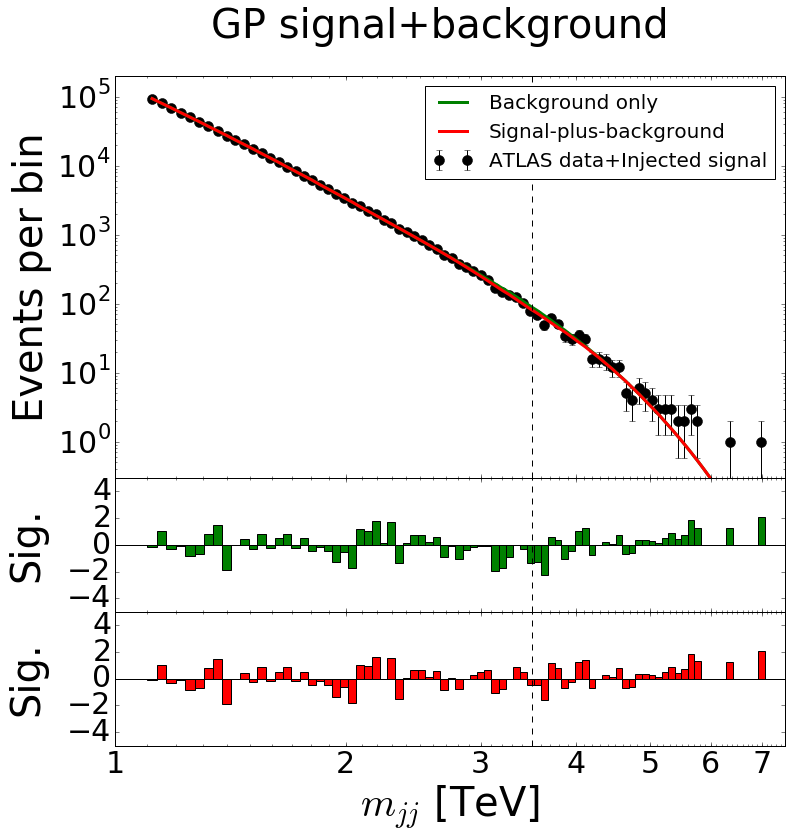

3500
background only time: 0.00289297103882
best fit mass 2733.5340232
background + signal time: 0.0582849979401
chi2 bkg+signal mu=0 165.702843378
chi2 bkg+signal 156.084419485


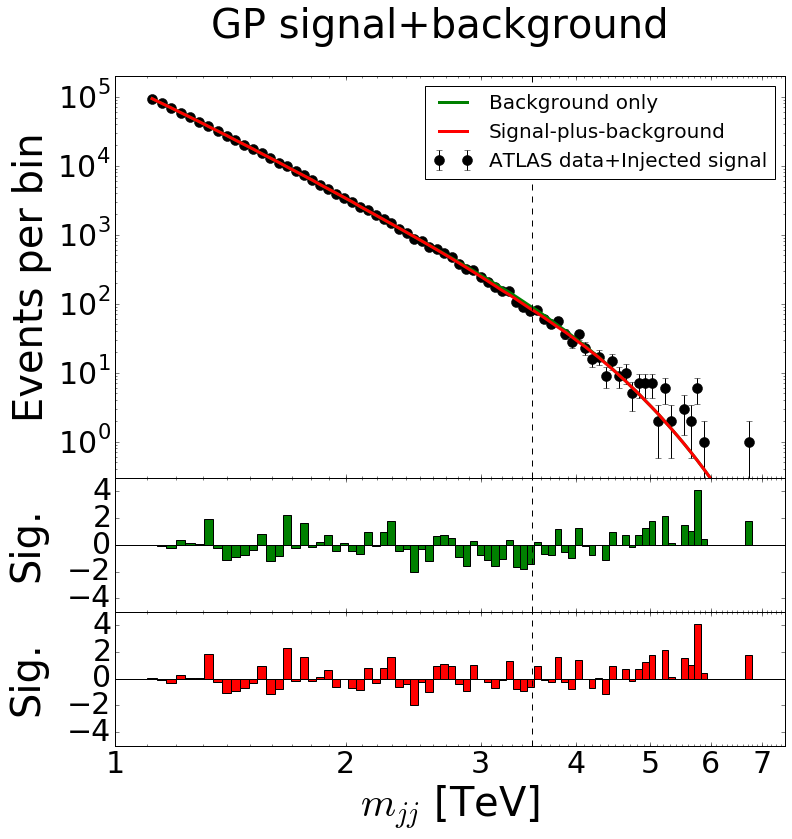

4000
background only time: 0.00329399108887
best fit mass 2913.64152346
background + signal time: 0.0786969661713
chi2 bkg+signal mu=0 121.71252322
chi2 bkg+signal 115.363049213


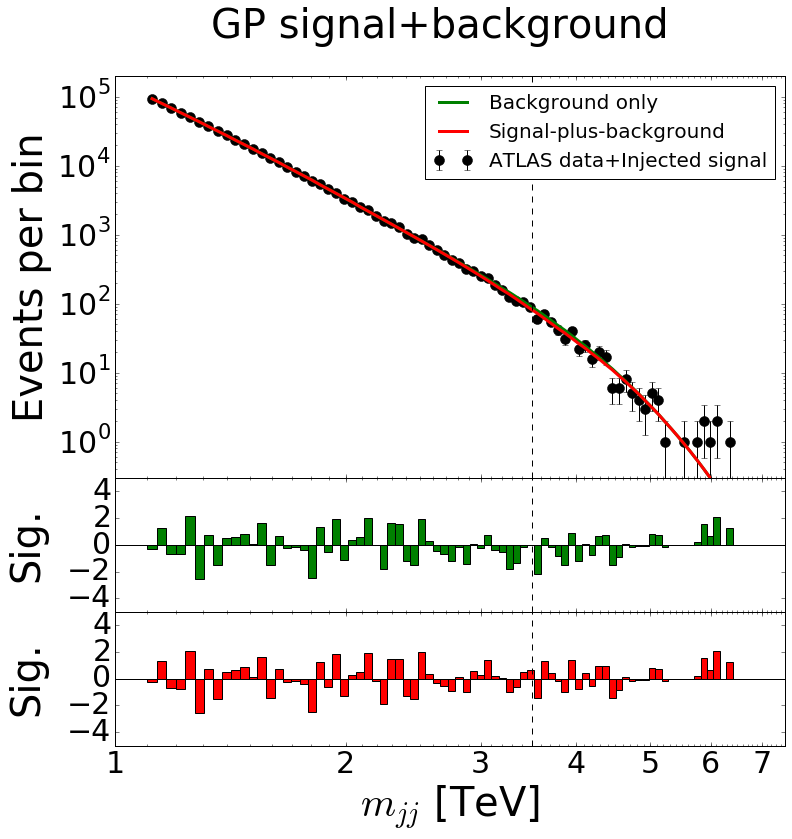

4500
background only time: 0.0052649974823
best fit mass 2546.67801578
background + signal time: 0.0598449707031
chi2 bkg+signal mu=0 182.189939599
chi2 bkg+signal 175.220417396


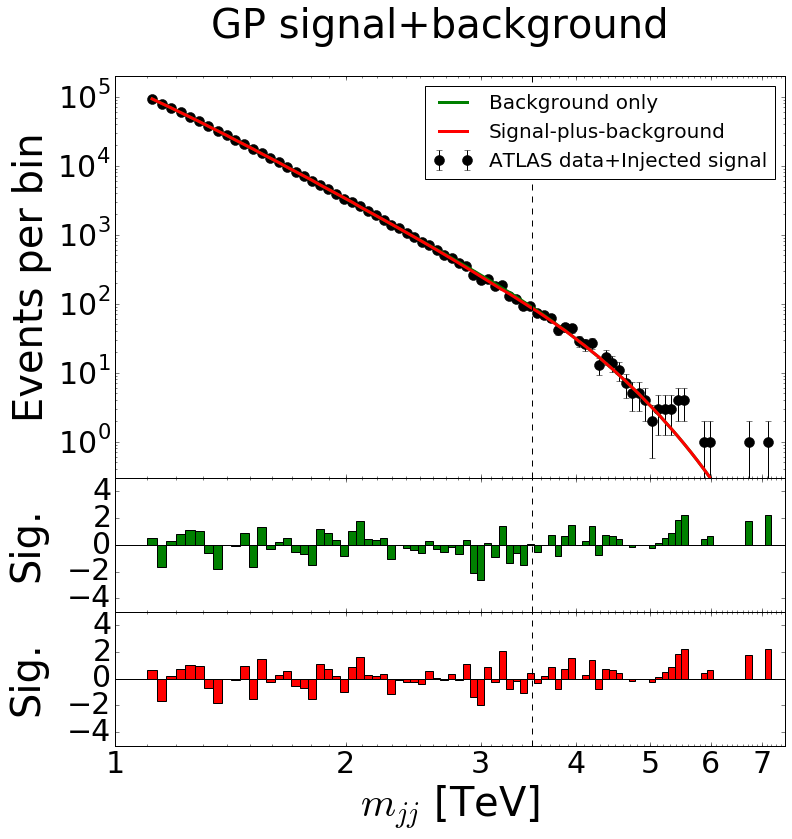

5000
background only time: 0.00309705734253
best fit mass 2741.17890651
background + signal time: 0.0609951019287
chi2 bkg+signal mu=0 143.833184875
chi2 bkg+signal 134.898772482


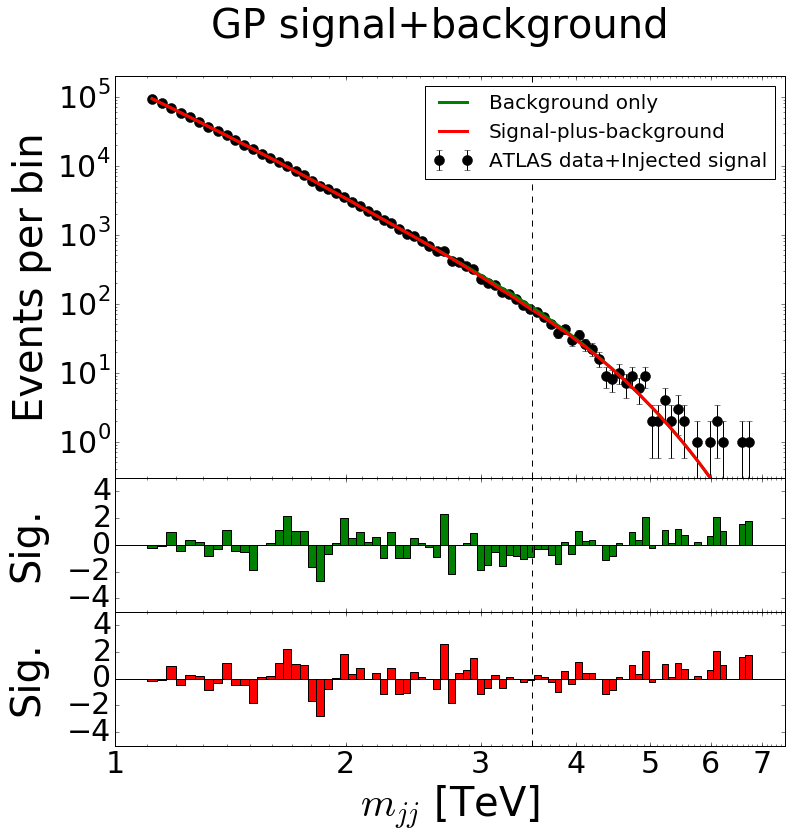

5500
background only time: 0.00324201583862
best fit mass 2652.62122903
background + signal time: 0.0308208465576
chi2 bkg+signal mu=0 252.205354634
chi2 bkg+signal 247.842134526


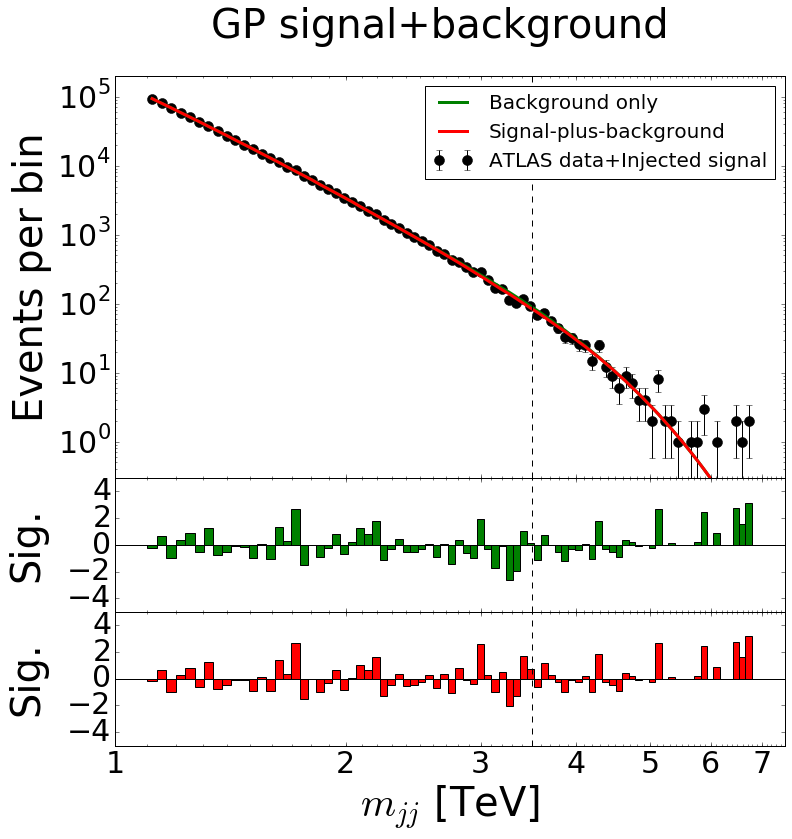

6000
background only time: 0.0041937828064
best fit mass 2698.44823334
background + signal time: 0.122164964676
chi2 bkg+signal mu=0 440.438972786
chi2 bkg+signal 437.032172324


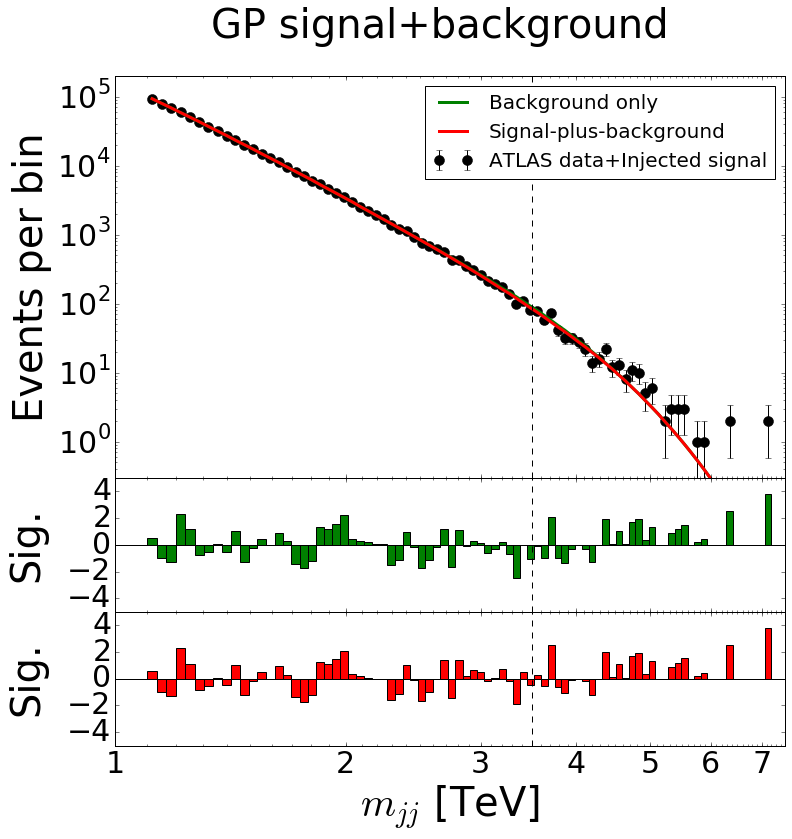

6500
background only time: 0.00329685211182
best fit mass 2730.85438388
background + signal time: 0.0289878845215
chi2 bkg+signal mu=0 175.107713411
chi2 bkg+signal 155.962686771


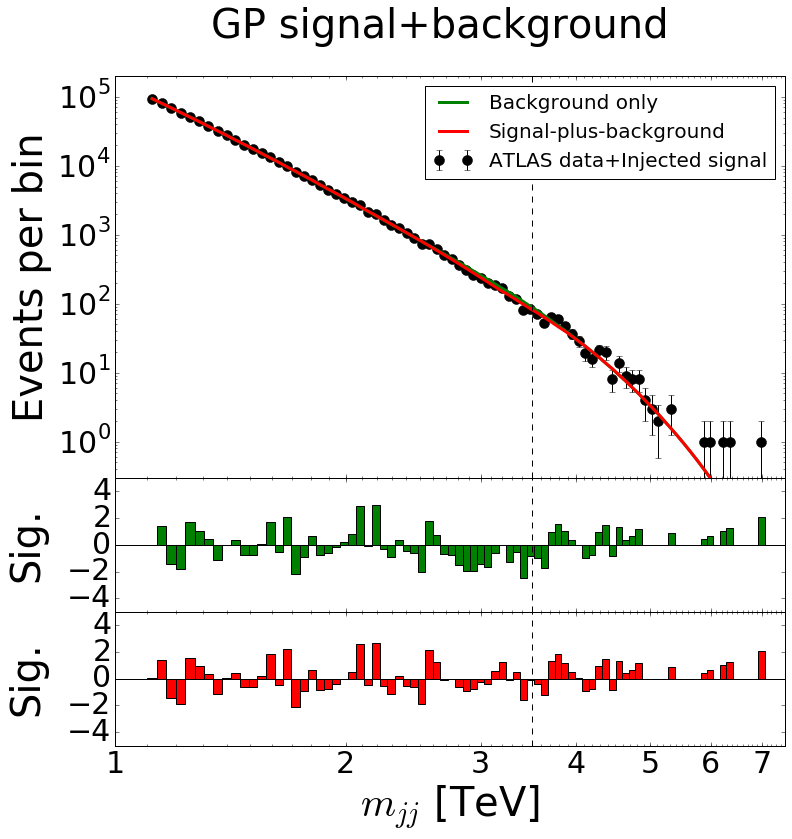

7000
background only time: 0.0041389465332
best fit mass 2863.13487285
background + signal time: 0.0414710044861
chi2 bkg+signal mu=0 84.001865639
chi2 bkg+signal 72.2313728659


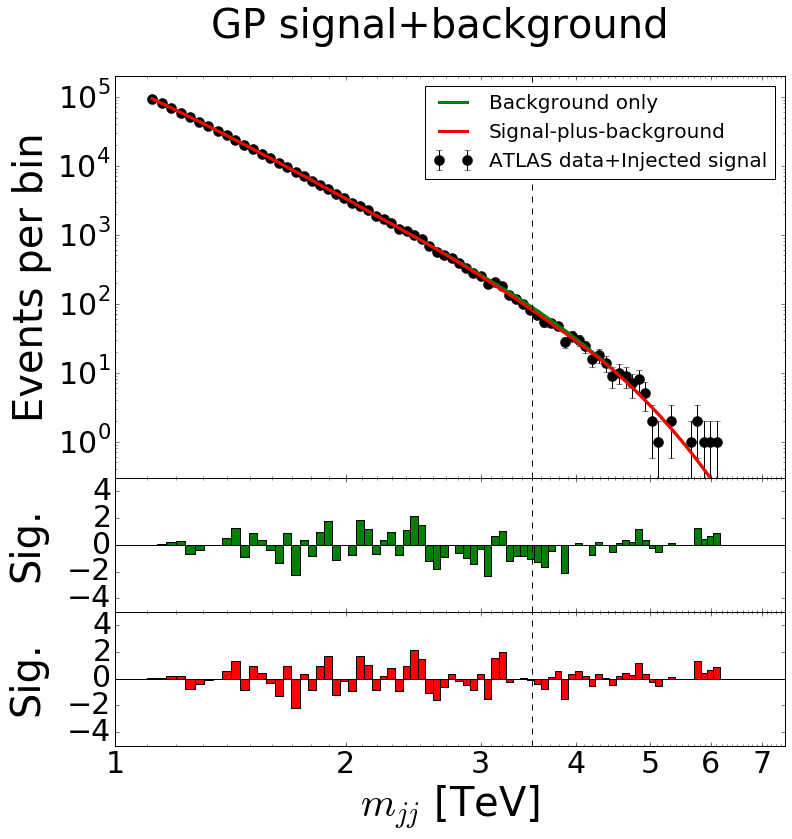

7500
background only time: 0.00322914123535
best fit mass 2678.252206
background + signal time: 0.0428202152252
chi2 bkg+signal mu=0 132.818019991
chi2 bkg+signal 127.530853924


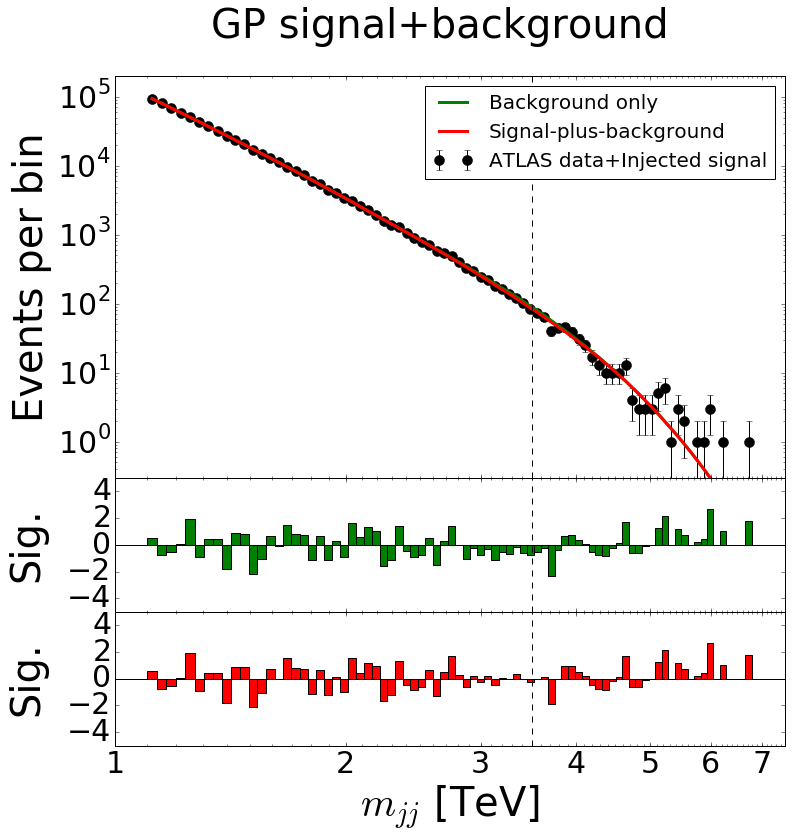

8000
background only time: 0.00292015075684
best fit mass 3473.8746711
background + signal time: 0.0745189189911
chi2 bkg+signal mu=0 583.596224783
chi2 bkg+signal 579.161838213


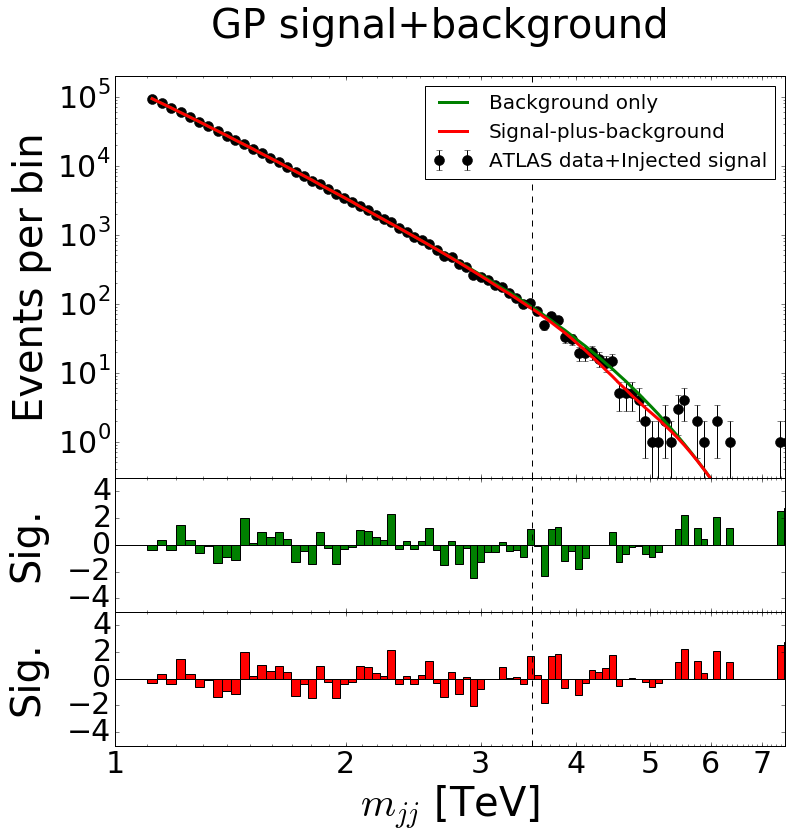

8500
background only time: 0.00339388847351
best fit mass 2345.14180878
background + signal time: 0.0375440120697
chi2 bkg+signal mu=0 601.884811523
chi2 bkg+signal 598.406319827


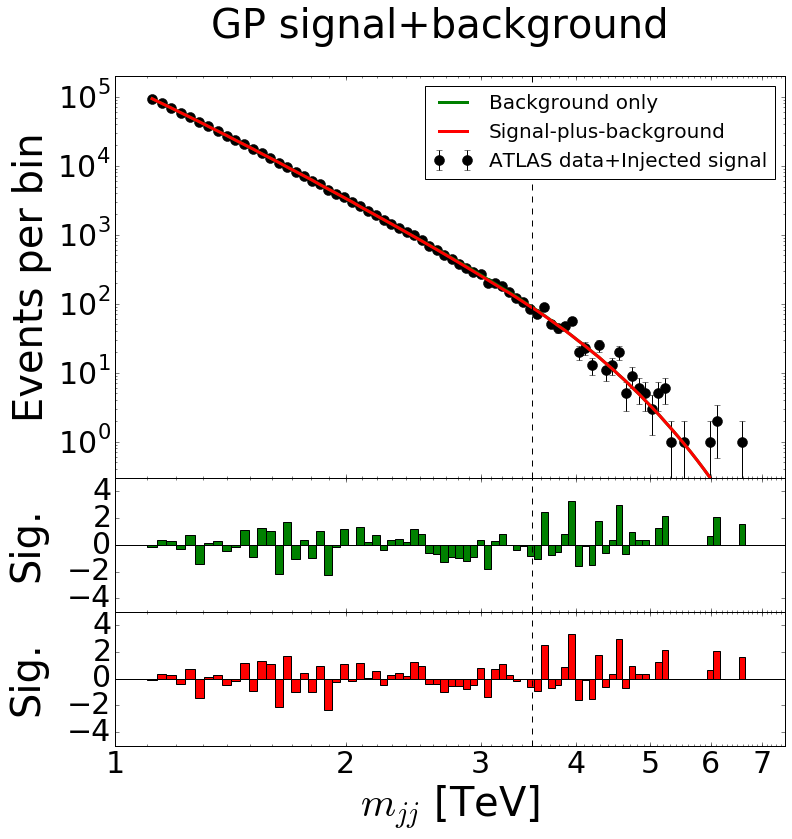

9000
background only time: 0.00613403320312
best fit mass 2916.24935694
background + signal time: 0.0570900440216
chi2 bkg+signal mu=0 109.642126308
chi2 bkg+signal 95.5601810986


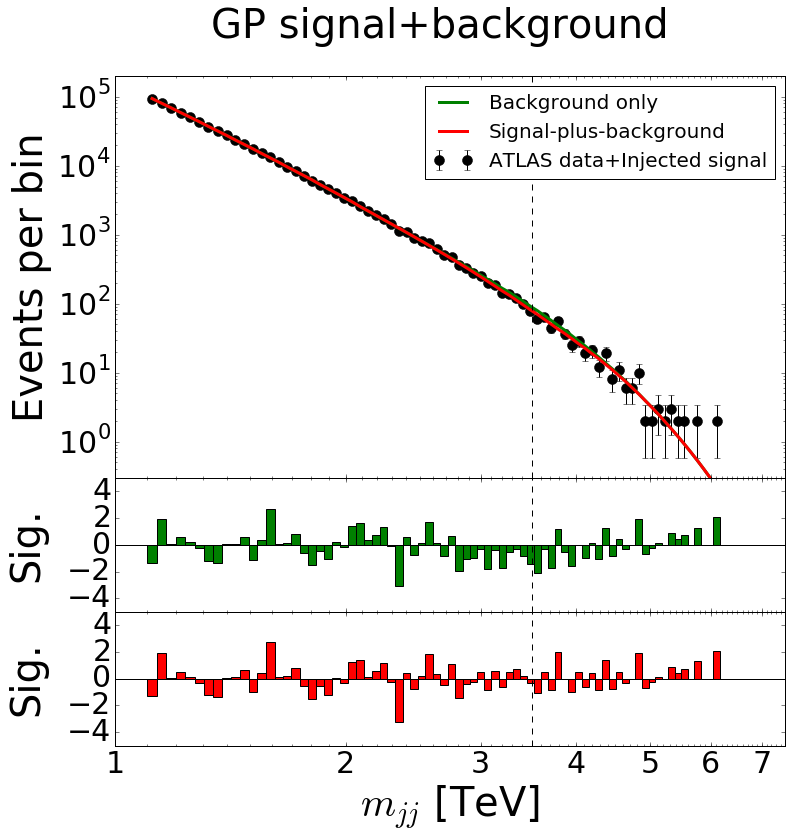

9500
background only time: 0.00344491004944
best fit mass 2950.45013143
background + signal time: 0.0314939022064
chi2 bkg+signal mu=0 289.08255491
chi2 bkg+signal 265.969592661


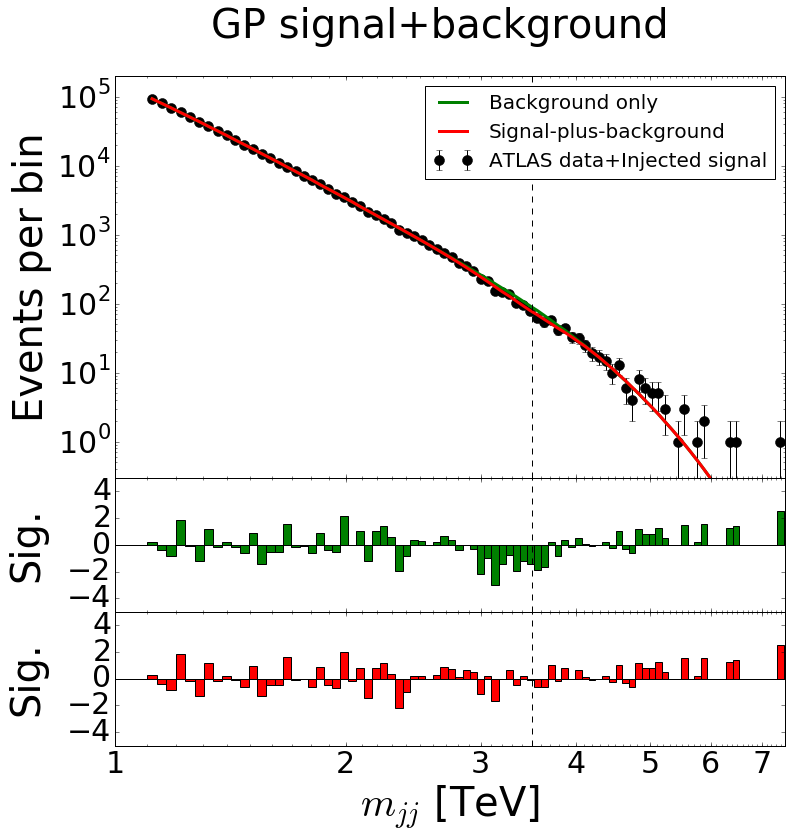

took 0.202538705005hours


In [123]:
toyList = np.load("newoutputs/toyList_3500.npy")
fixedHyperparams = np.load("newoutputs/fixedHyperparams_3500.npy")
if runOnlyFF: pass
else: 
    btime=time.time()

    #LLH ratio george likelihood
    LLlistGP_largeL={}


    standardParamSets = [(300, 3500, 250)]
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP_largeL[m]=[]

        
        for itoy, toy in enumerate(toyList):
            if not itoy%500: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            ydata = ytoy

            ydataO = toy

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()   
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            lnProb = logLike_gp_fitM_fixedH(xtoy,ydata, xtoyerr, (200, 600, 600))
            minLLH, best_fit_gp = fit_gp_fitM_fixedH_minuit(lnProb, False)
            #print best_fit_gp
            if np.isinf(minLLH): 
                continue  
                
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 200, best_fit_gp[0], 600, 600
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

            if not itoy%500:
                print "best fit mass", best_fit_gp[0]
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
                makePrettyPlots_signal(xvalO, ydataO, MAP1, MAP, "GP signal+background", 3500, col = 'g', ymax = 2e5)
        

            #LLlistGP_largeL[m].append(-2*(gpLLH-gpLLHSig))
            LLlistGP_largeL[m].append(-2*(-logLike_gpLikeFF(ydataO, MAP1)+logLike_gpLikeFF(ydataO, MAP)))


    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

(300, 3500, 250)
0
background only time: 0.00379300117493
best fit mass 2000.0
background + signal time: 0.0282828807831
chi2 bkg+signal mu=0 273.364181652
chi2 bkg+signal 272.993413584


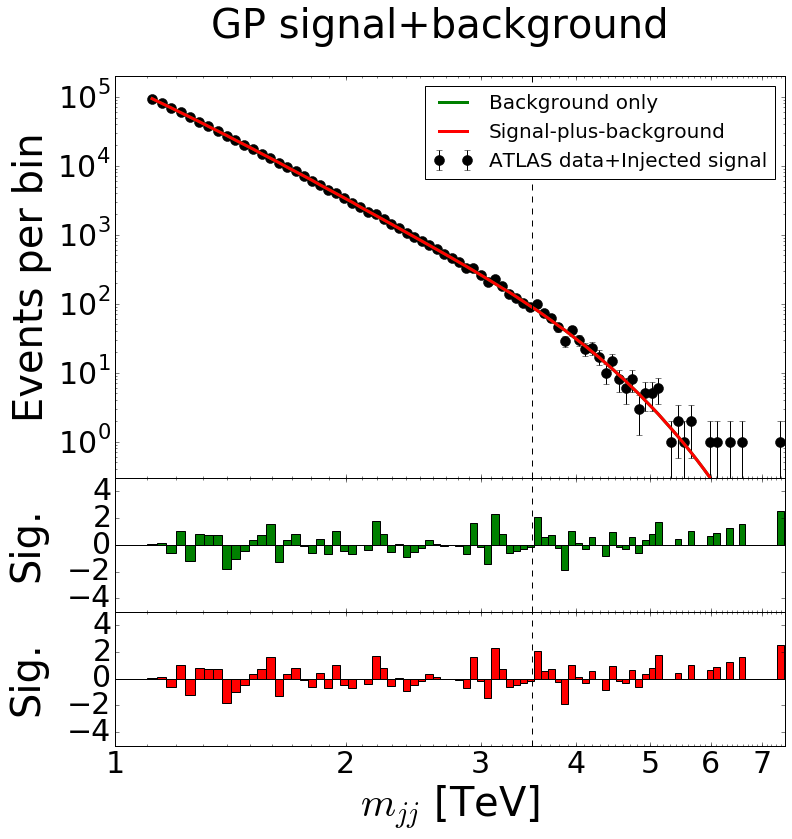

500
background only time: 0.003005027771
best fit mass 2784.64045895
background + signal time: 0.0590138435364
chi2 bkg+signal mu=0 928.004914258
chi2 bkg+signal 917.981334553


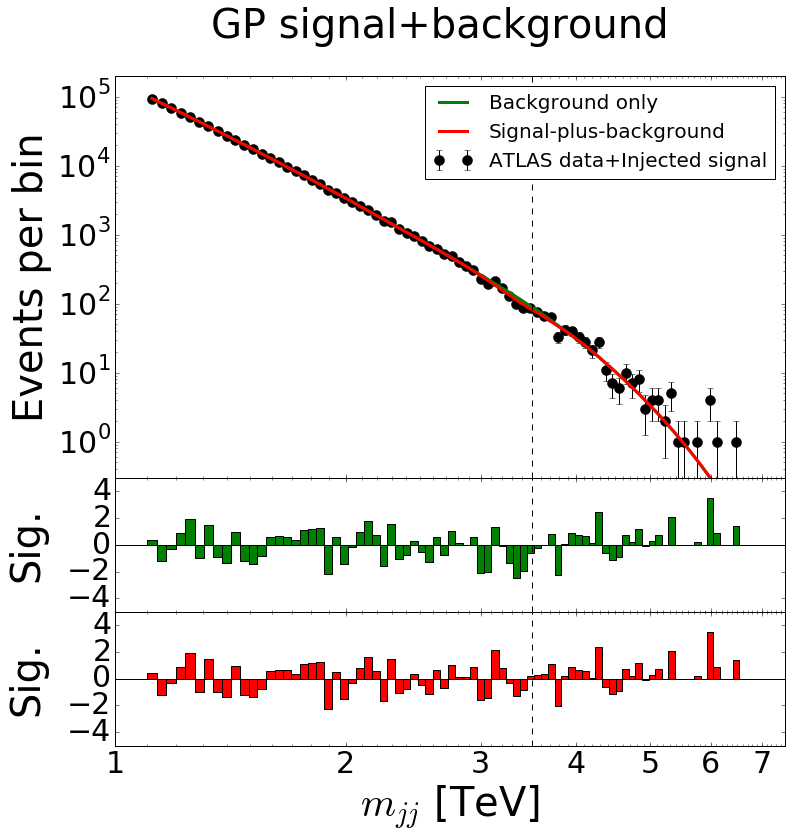

1000
background only time: 0.00374698638916
best fit mass 2382.51768004
background + signal time: 0.0507829189301
chi2 bkg+signal mu=0 204.407319533
chi2 bkg+signal 198.415138722


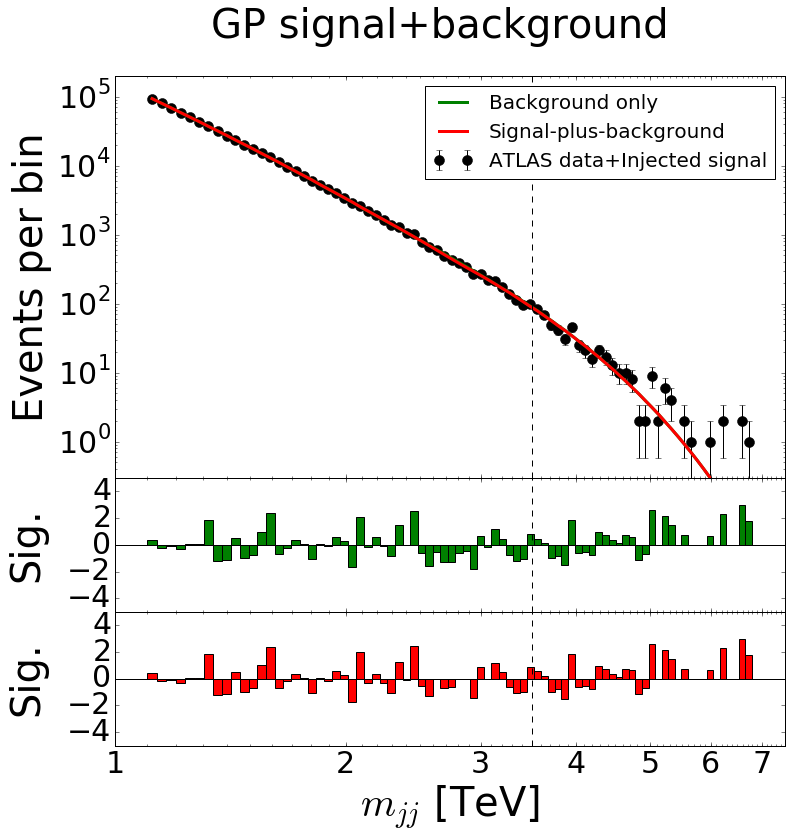

1500
background only time: 0.00302314758301
best fit mass 3342.51241295
background + signal time: 0.0272719860077
chi2 bkg+signal mu=0 160.513565034
chi2 bkg+signal 151.265695187


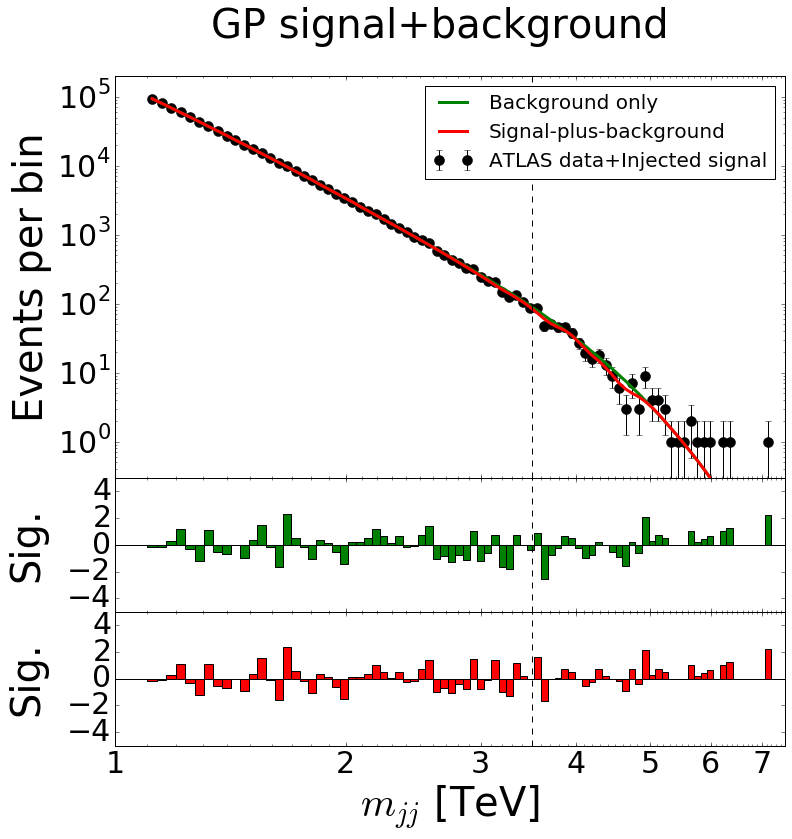

2000
background only time: 0.0029981136322
best fit mass 2562.43363815
background + signal time: 0.0268318653107
chi2 bkg+signal mu=0 142.501556844
chi2 bkg+signal 135.456817416


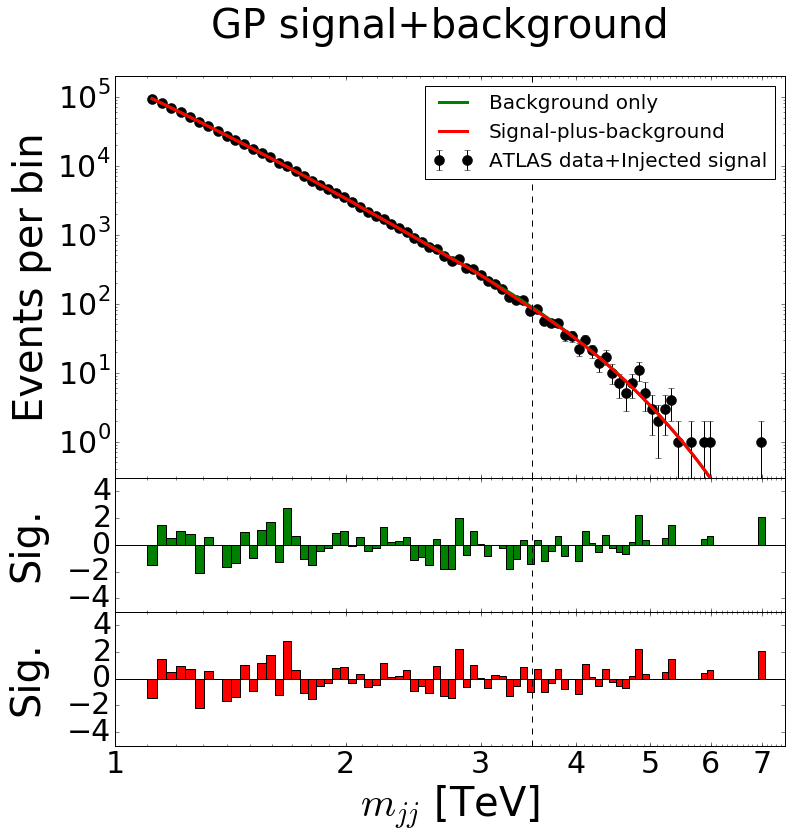

2500
background only time: 0.00500011444092
best fit mass 2743.98702718
background + signal time: 0.0674779415131
chi2 bkg+signal mu=0 95.9351842101
chi2 bkg+signal 81.0106746244


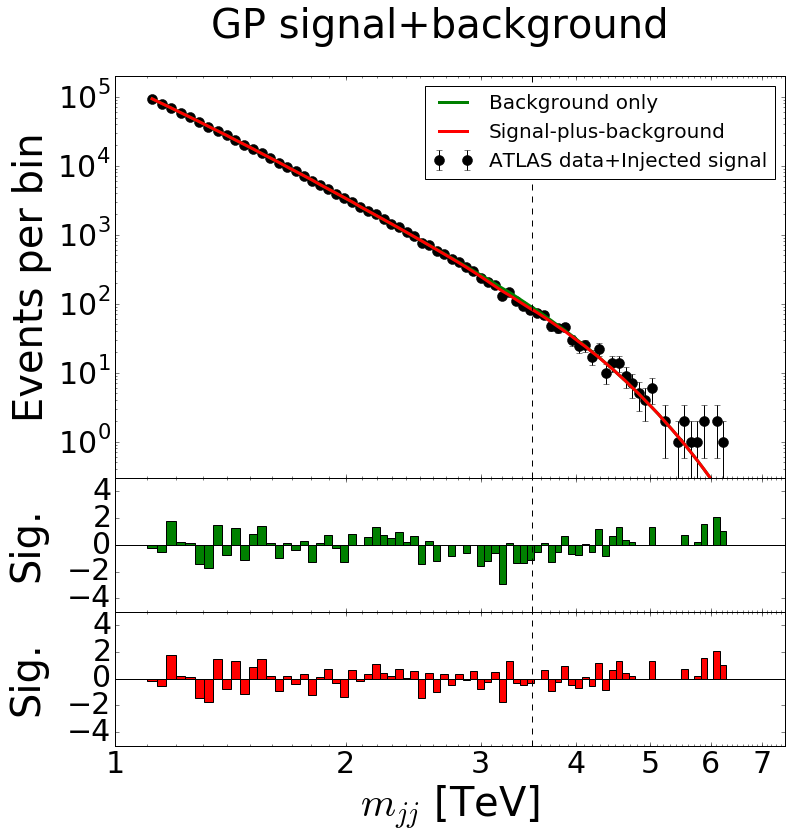

3000
background only time: 0.00310182571411
best fit mass 2743.70360552
background + signal time: 0.0573651790619
chi2 bkg+signal mu=0 130.944217586
chi2 bkg+signal 120.137013809


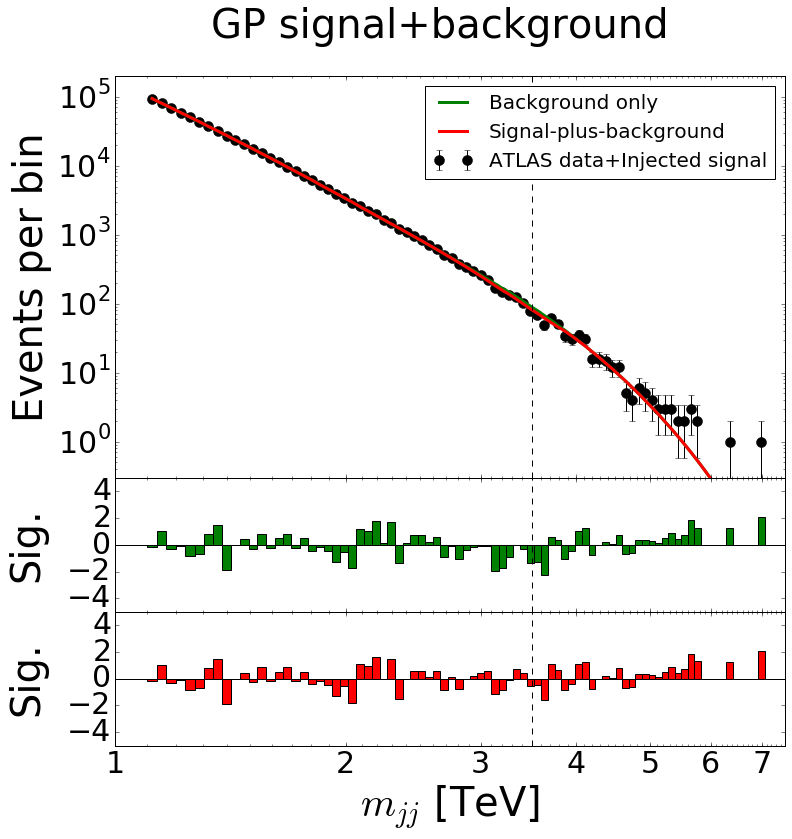

3500
background only time: 0.00291109085083
best fit mass 2700.27314421
background + signal time: 0.0588729381561
chi2 bkg+signal mu=0 165.702843378
chi2 bkg+signal 154.631232817


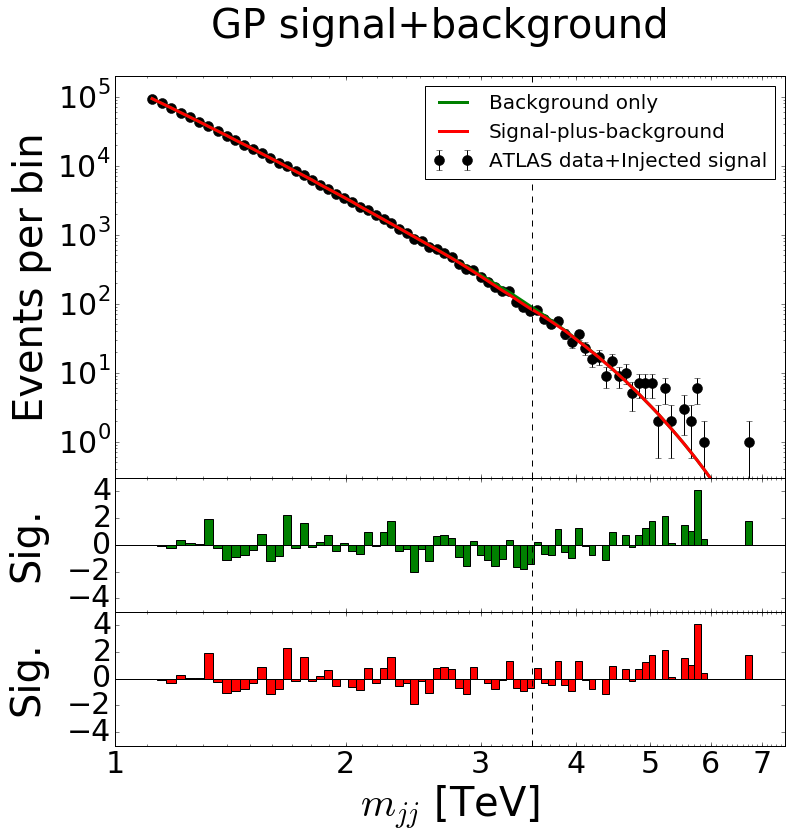

4000
background only time: 0.00314784049988
best fit mass 2787.18752389
background + signal time: 0.0567429065704
chi2 bkg+signal mu=0 121.71252322
chi2 bkg+signal 113.418485792


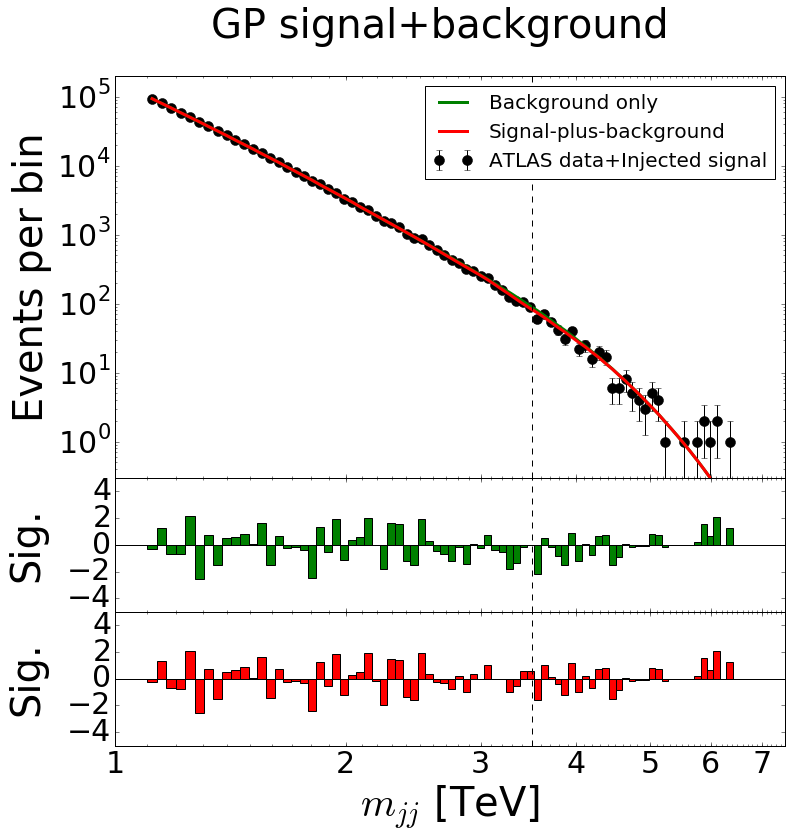

4500
background only time: 0.00640201568604
best fit mass 2529.19976998
background + signal time: 0.102714061737
chi2 bkg+signal mu=0 182.189939599
chi2 bkg+signal 174.312888243


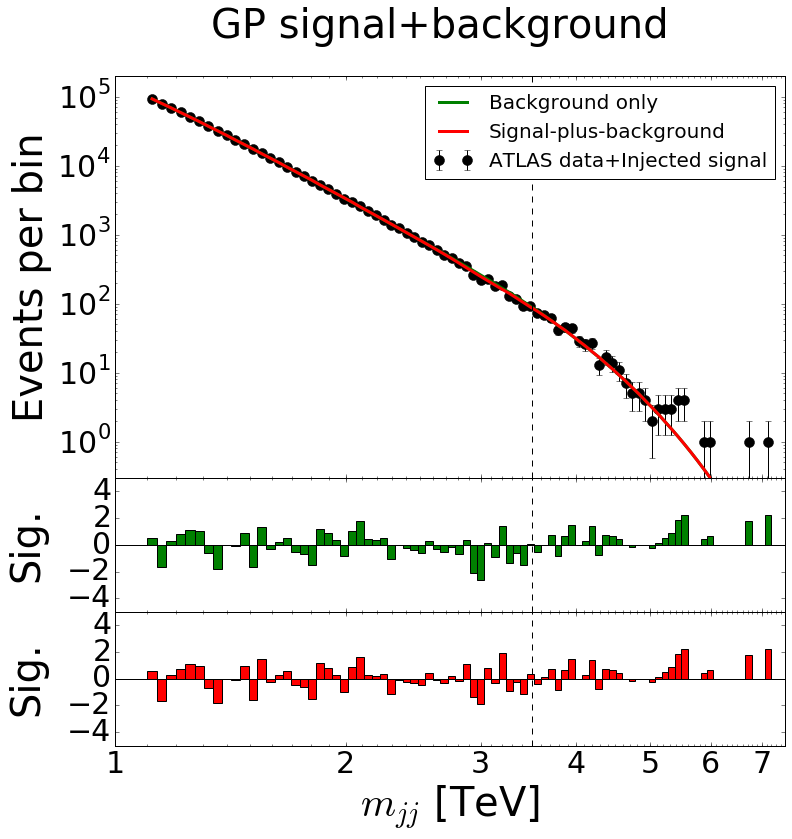

5000
background only time: 0.0050060749054
best fit mass 2717.08647525
background + signal time: 0.0554530620575
chi2 bkg+signal mu=0 143.833184875
chi2 bkg+signal 133.781860068


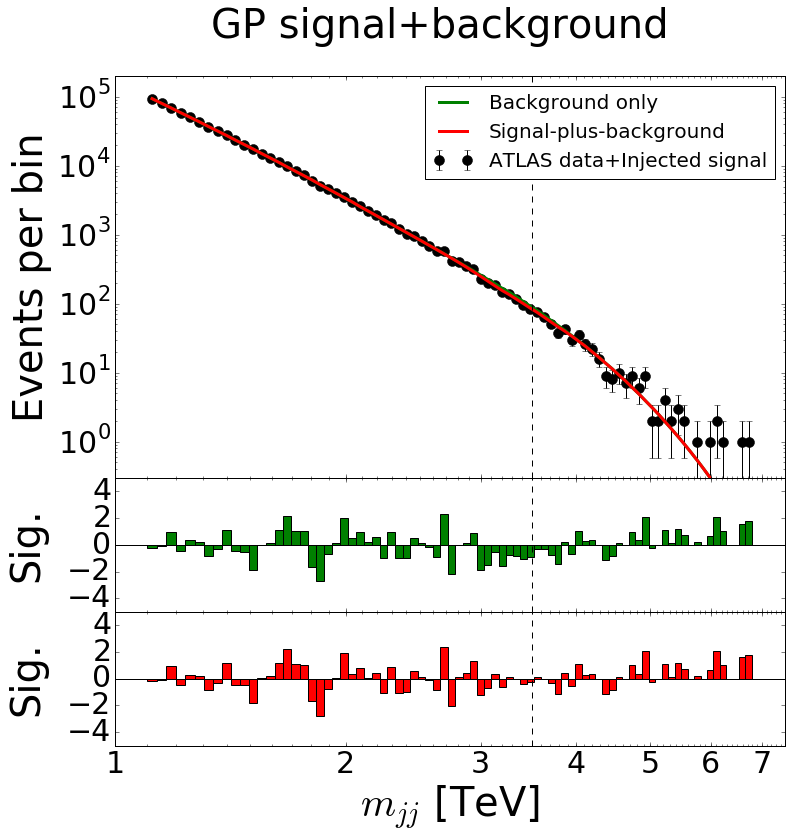

5500
background only time: 0.00833916664124
best fit mass 2735.5132253
background + signal time: 0.124320030212
chi2 bkg+signal mu=0 252.205354634
chi2 bkg+signal 244.28933181


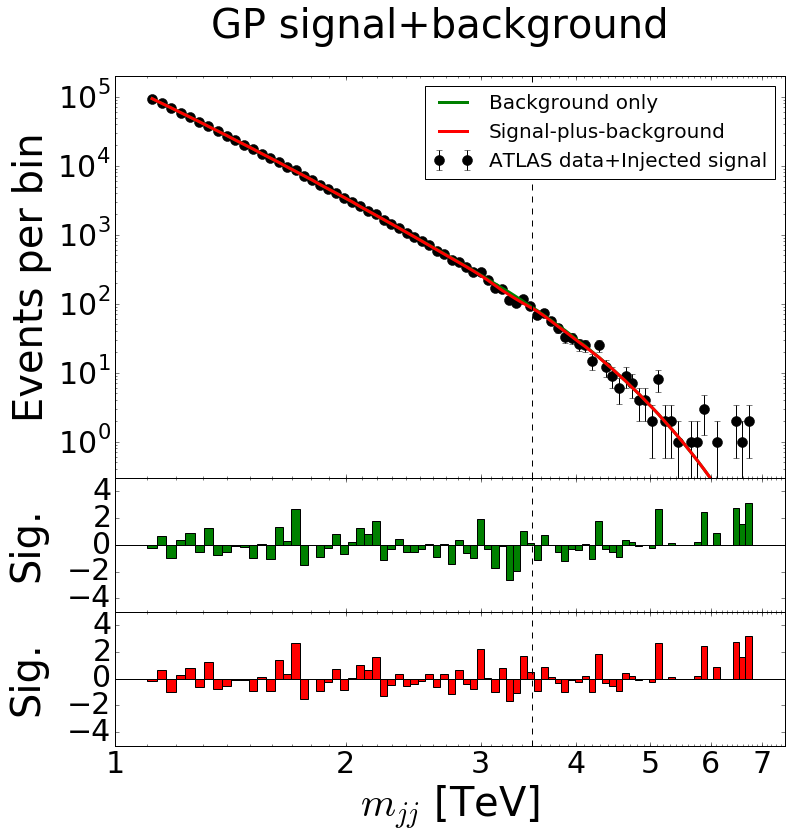

6000
background only time: 0.00291514396667
best fit mass 2549.92607126
background + signal time: 0.0275478363037
chi2 bkg+signal mu=0 440.438972786
chi2 bkg+signal 433.54013588


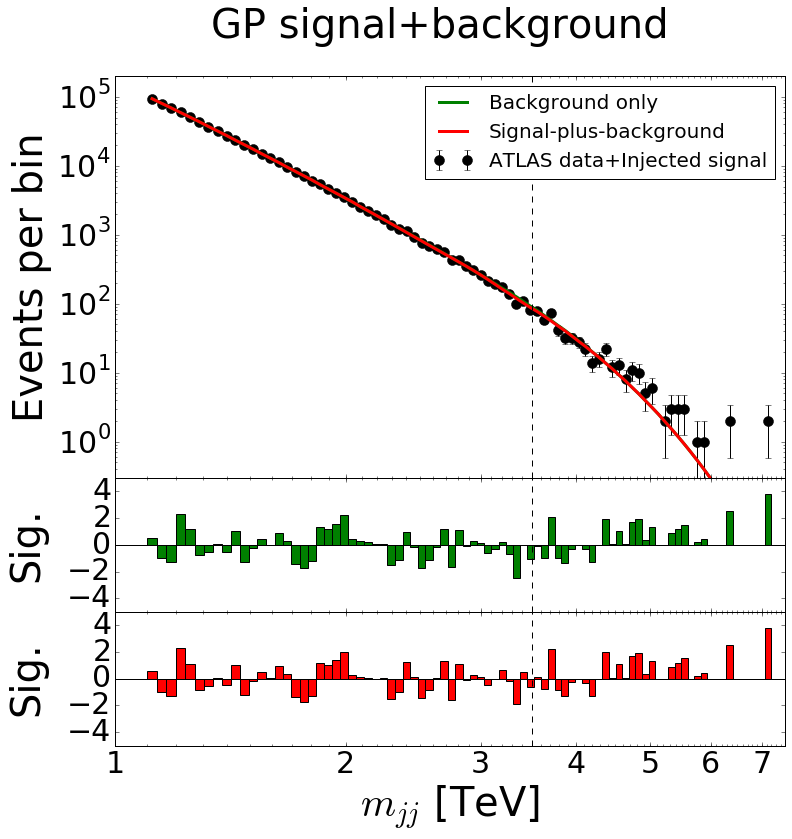

6500
background only time: 0.00307202339172
best fit mass 2908.75330983
background + signal time: 0.0349338054657
chi2 bkg+signal mu=0 175.107713411
chi2 bkg+signal 148.657518461


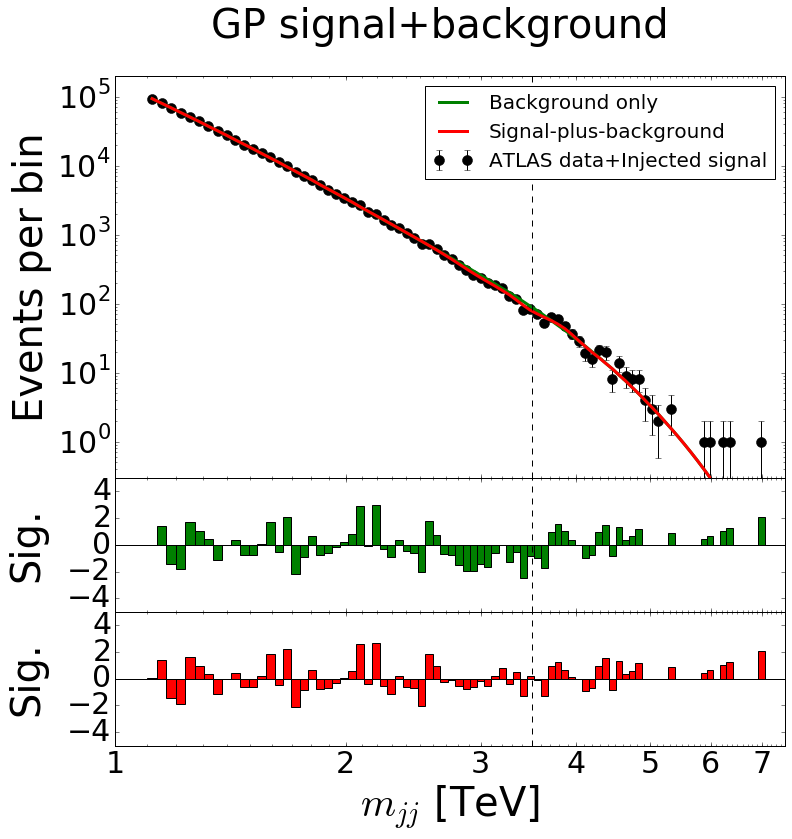

7000
background only time: 0.00300598144531
best fit mass 2828.80012714
background + signal time: 0.0653750896454
chi2 bkg+signal mu=0 84.001865639
chi2 bkg+signal 68.306240529


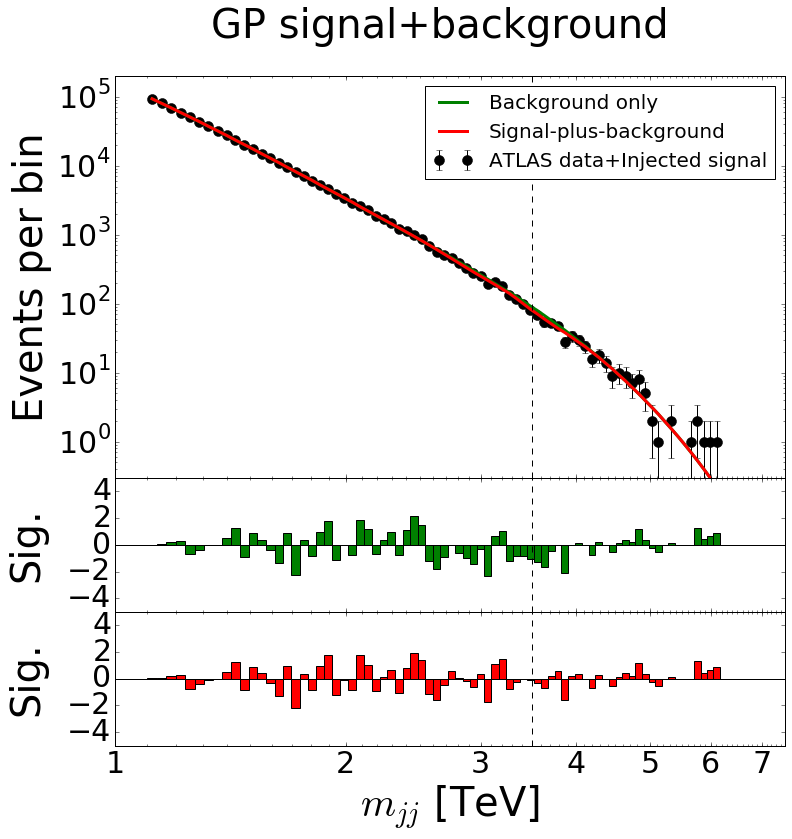

7500
background only time: 0.00692510604858
best fit mass 2663.28288473
background + signal time: 0.0695080757141
chi2 bkg+signal mu=0 132.818019991
chi2 bkg+signal 126.138542287


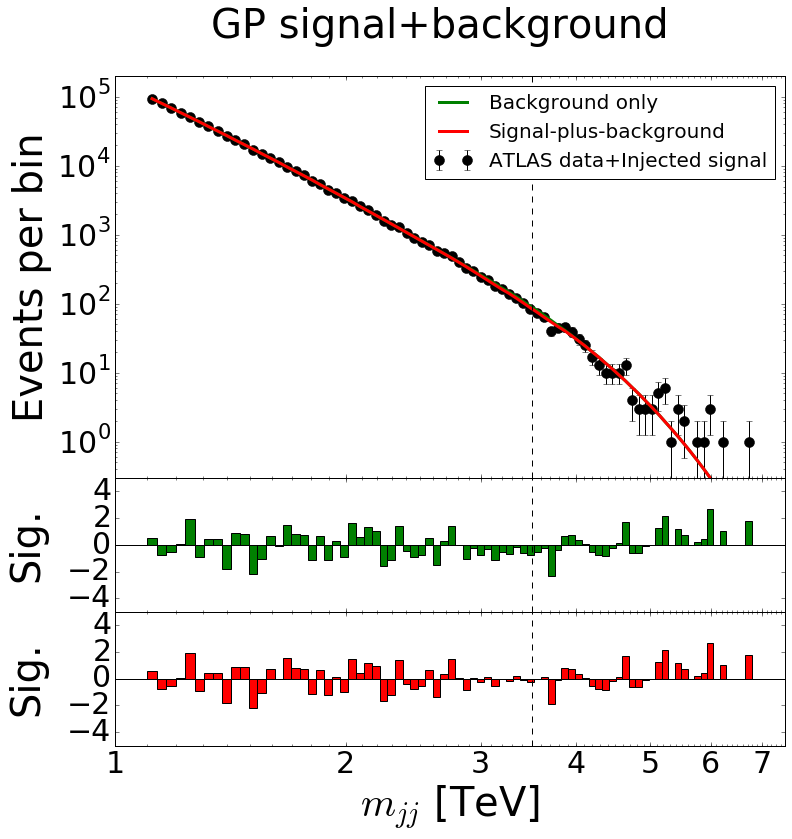

8000
background only time: 0.00308012962341
best fit mass 2901.21410845
background + signal time: 0.0771970748901
chi2 bkg+signal mu=0 583.596224783
chi2 bkg+signal 572.823548627


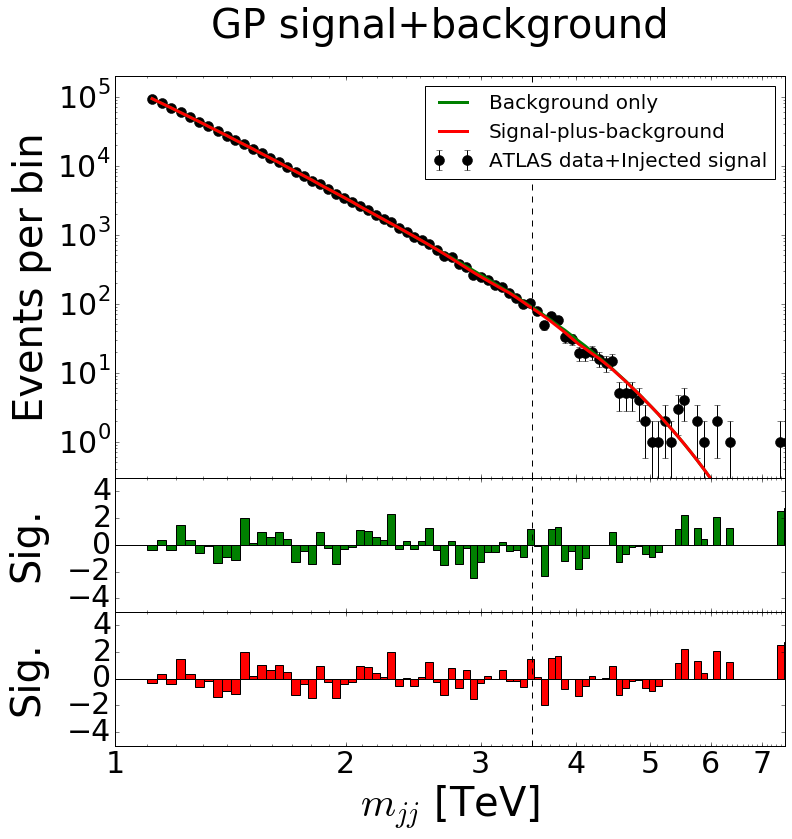

8500
background only time: 0.00514698028564
best fit mass 2316.08824704
background + signal time: 0.0671119689941
chi2 bkg+signal mu=0 601.884811523
chi2 bkg+signal 595.661976984


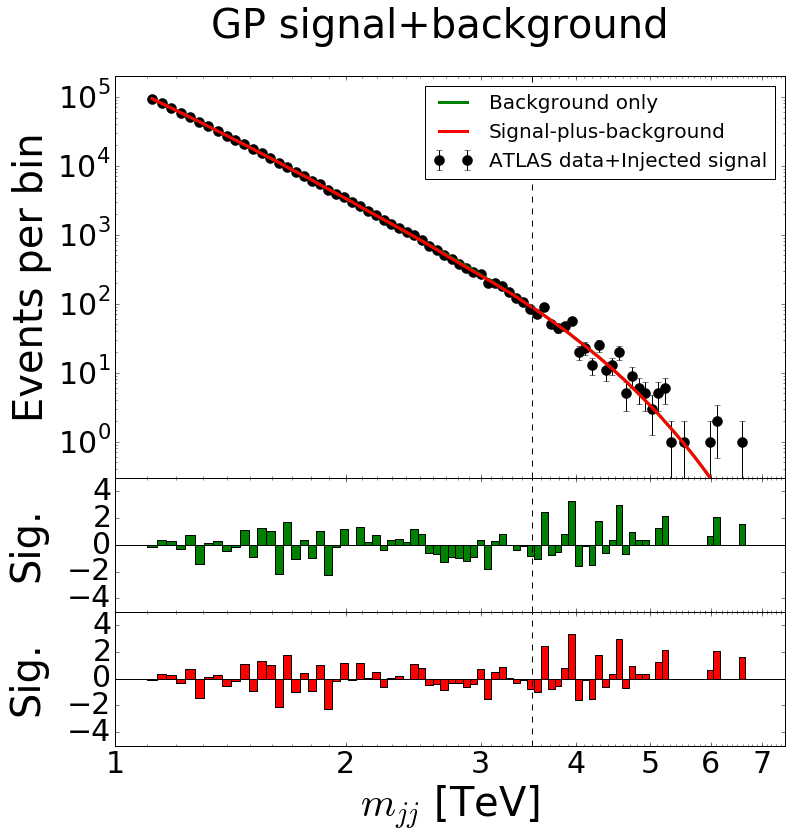

9000
background only time: 0.00297403335571
best fit mass 2897.47796399
background + signal time: 0.0788300037384
chi2 bkg+signal mu=0 109.642126308
chi2 bkg+signal 93.7279142884


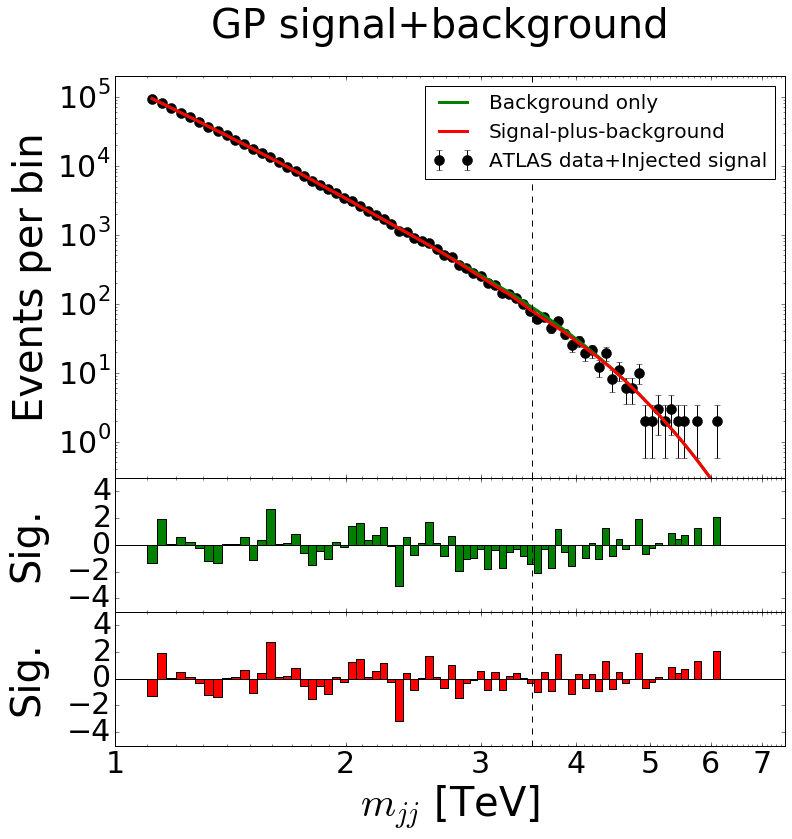

9500
background only time: 0.00318217277527
best fit mass 2893.50615392
background + signal time: 0.061420917511
chi2 bkg+signal mu=0 289.08255491
chi2 bkg+signal 263.080948755


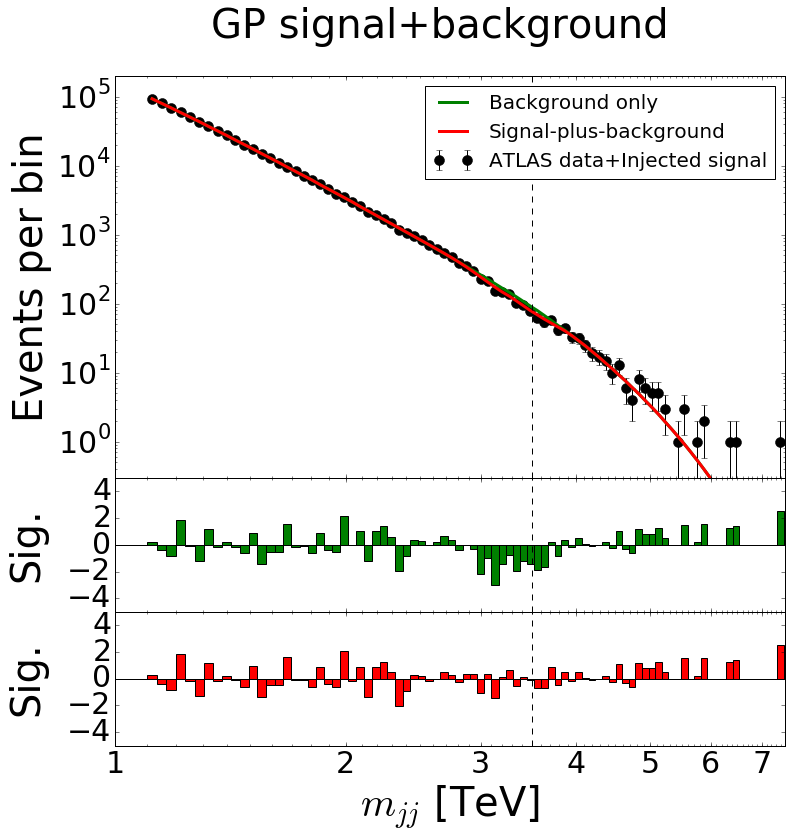

took 0.199238897231hours


In [124]:
#sigToys = np.load("newoutputs/signalToys_3500.npy")
#sigToysO = np.load("newoutputs/signalToysO_3500.npy")
#toyList = np.load("newoutputs/toyList_3500.npy")
if runOnlyFF: pass
else: 
    btime=time.time()

    #LLH ratio george likelihood
    LLlistGP_smallL={}

    standardParamSets = [(300, 3500, 250)]
    for pSet in standardParamSets:
        n, m, w = pSet
        print pSet
        LLlistGP_smallL[m]=[]

        
        for itoy, toy in enumerate(toyList):
            if not itoy%500: 
                print itoy
            ytoy, xtoy, xtoyerr = removeZeros(toy)
            ydata = ytoy 

            ydataO = toy 

            #BACKGROUND ONLY FIT GP
            if not itoy%500:
                pgpb_stime = time.time()
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            gp1 = george.GP(kernel1)
            gp1.compute(xtoy, np.sqrt(ydata))
            MAP1p, covGP1 = gp1.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP1 = MAP1p + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLH = gp1.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))
            if not itoy%500:
                pgpb_etime = time.time()
                print "background only time:", pgpb_etime-pgpb_stime

            #BACKGROUND+SIGNAL FIT GP
            if not itoy%500:
                pgpsb_stime = time.time()
            lnProb = logLike_gp_fitM_fixedH(xtoy,ydata, xtoyerr, (200, 600, 200))
            minLLH, best_fit_gp = fit_gp_fitM_fixedH_minuit(lnProb, False)
            #print best_fit_gp
            if np.isinf(minLLH): 
                continue  
            Amp, decay, length, power, sub, p0, p1, p2 = fixedHyperparams
            A, mass, tau, L = 200, best_fit_gp[0], 600, 200
            kernel1 = Amp * MyDijetKernelSimp(a = decay, b = length, c = power, d = sub)
            kernel2 = A * SignalKernel(m = mass, t = tau, L=L)
            kernel = kernel1+kernel2
            gp = george.GP(kernel)
            gp.compute(xtoy, np.sqrt(ydata))
            MAPp, covGP = gp.predict(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr), xvalO)
            MAP = MAPp + model_3param(xvalO,(p0,p1,p2),xerrO)
            gpLLHSig = gp.lnlikelihood(ydata - model_gp((p0,p1,p2),xtoy, xtoyerr))

            if not itoy%500:
                print "best fit mass", best_fit_gp[0]
                pgpsb_etime = time.time()
                print "background + signal time:", pgpsb_etime - pgpsb_stime
                makePrettyPlots_signal(xvalO, ydataO, MAP1, MAP, "GP signal+background", 3500, col = 'g', ymax = 2e5)
        

            #LLlistGP_smallL[m].append(-2*(gpLLH-gpLLHSig))
            LLlistGP_smallL[m].append(-2*(-logLike_gpLikeFF(ydataO, MAP1)+logLike_gpLikeFF(ydataO, MAP)))




    etime = time.time()
    print "took "+str((etime-btime)/(60.*60.)) + "hours"  

george LL% < 0:  0.03
george LL% < 0:  0.43


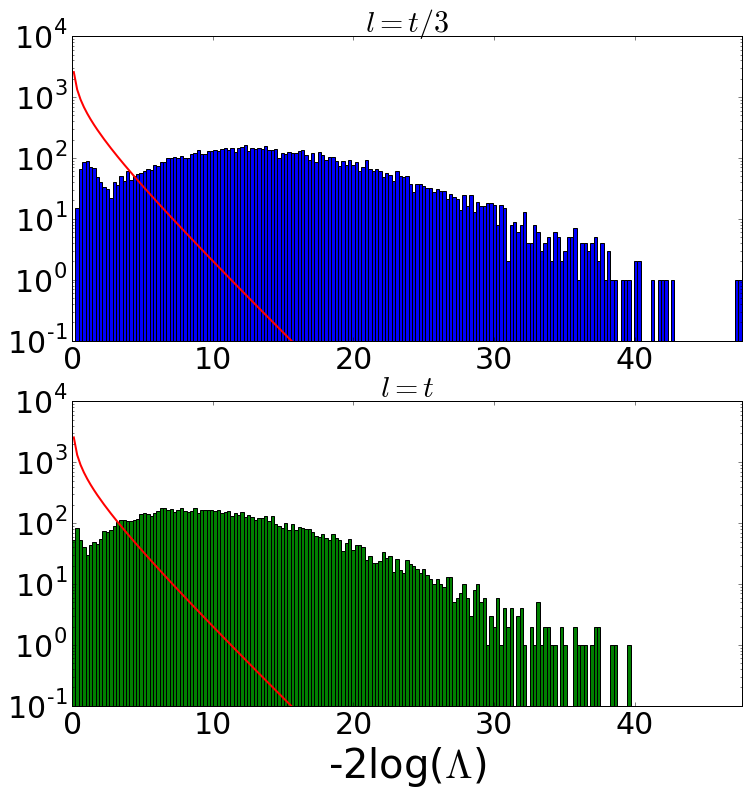

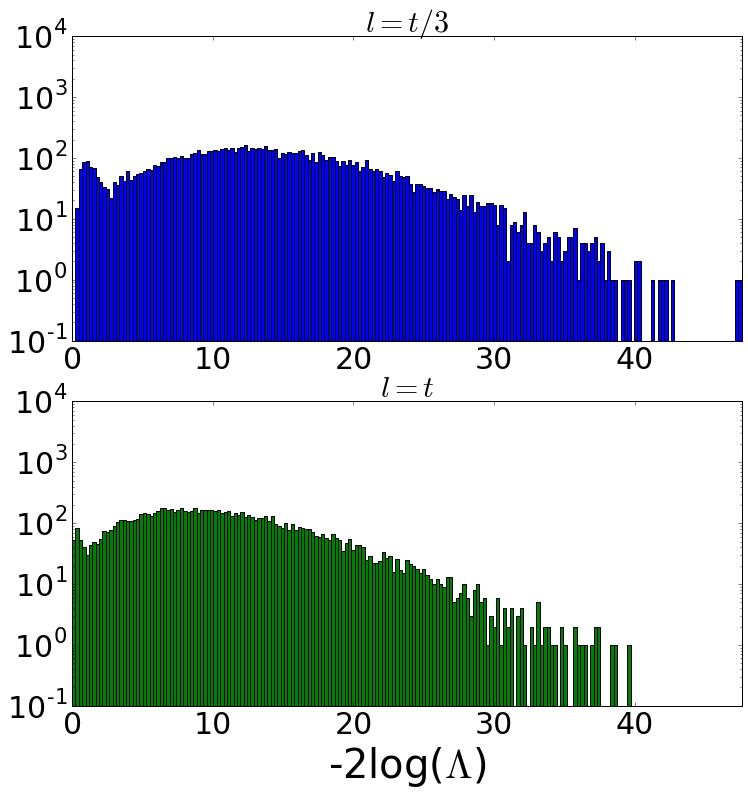

In [128]:
msignals = [standardParamSets[i][1] for i in range(len(standardParamSets))]

for m in msignals:
    gp_smallL = [s for s in LLlistGP_smallL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_smallL = round(100.*sum(i < 0 for i in gp_smallL)/len(gp_smallL),2)
    print "george LL% < 0: ", gp_neg_frac_smallL
    
    gp_smallL = [s for s in gp_smallL if s > 0]
    
    gp_largeL = [s for s in LLlistGP_largeL[m] if not (np.isinf(s) or np.isnan(s))]
    
    gp_neg_frac_largeL = round(100.*sum(i < 0 for i in gp_largeL)/len(gp_largeL),2)
    print "george LL% < 0: ", gp_neg_frac_largeL
    
    gp_largeL = [s for s in gp_largeL if s > 0]
    
    label = r"-2log($\Lambda$) for mass "+str(int(m))
    makePrettyPlots_LLH(gp_smallL, gp_largeL, label, drawchi2=True, xname = r"-2log($\Lambda$)", label1 =r"$l = t/3$", label2 = r"$l = t$")
    
    makePrettyPlots_LLH(gp_smallL, gp_largeL, label, drawchi2=False, xname = r"-2log($\Lambda$)", label1 =r"$l = t/3$", label2 = r"$l = t$")

